In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit as sigmoid, logit

from utils.metric_utils import HardMetric
from sklearn.metrics import f1_score

import shap, lime, eli5
shap.initjs()

%matplotlib inline

In C:\Alon\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Alon\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Alon\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Alon\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Alon\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.jpeg_quality rc

In [6]:
VALIDATION = False
SAMPLE = False
SAMPLE_FRAC = 0.3
final_metric = HardMetric(f1_score)

In [7]:
train = pd.read_csv('data/train.csv',index_col = 'id')
test = pd.read_csv('data/test.csv',index_col = 'id')
data = pd.concat([train, test]).drop(columns = 'target')
sample_test = pd.read_csv('data/sample_submission.csv',index_col = 'id')

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [8]:
from sklearn.model_selection import train_test_split
if VALIDATION:
    if SAMPLE:
        data = train.sample(frac = SAMPLE_FRAC)
    else:
        data = train
    train, test = train_test_split(data, train_size=0.7, shuffle=True)
    y_test = test['target']
    test = test.drop(columns = 'target')
else:
    train = train.sample(frac = 1.)

In [9]:
train.shape, test.shape

((7613, 4), (3263, 3))

# Feature Extraction

## Keyword

In [10]:
from feature_extraction.keyword import process_keyword

keyword = data['keyword']
X_keyword = process_keyword(keyword)
X_keyword.sample(10)

,keyword_OH_ablaze,keyword_OH_accident,keyword_OH_aftershock,keyword_OH_airplane%20accident,keyword_OH_ambulance,keyword_OH_annihilated,keyword_OH_annihilation,keyword_OH_apocalypse,keyword_OH_armageddon,keyword_OH_army,...,keyword_OH_whirlwind,keyword_OH_wild%20fires,keyword_OH_wildfire,keyword_OH_windstorm,keyword_OH_wounded,keyword_OH_wounds,keyword_OH_wreck,keyword_OH_wreckage,keyword_OH_wrecked,keyword_isna
id,,,,,,,,,,,,,,,,,,,,,
9329,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
724,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5682,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2730,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2778,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
370,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10523,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
10440,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2766,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Text

In [13]:
from feature_extraction.text import process_text

text = data['text']
X_text = process_text(text)
X_text.sample(10)

,text_count_urls,text_count_large_words,text_count_small_words,text_count_words,text_count_large_words_frac,text_our,text_deeds,text_are,text_the,text_reason,...,text_reserve,text_hattrick,text_ebolaoutbreak,text_ala,text_issuicide,text_rajman,text_hasaka,text_risen,text_fasteners,text_xrwn
id,,,,,,,,,,,,,,,,,,,,,
8811,0,9,5,17,0.526316,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3078,0,1,25,28,0.035587,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1860,0,1,16,19,0.052356,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4184,0,6,17,23,0.259740,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8376,0,3,22,28,0.106762,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7965,2,5,6,12,0.413223,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4861,0,1,19,22,0.045249,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2081,0,2,13,19,0.104712,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2848,1,5,6,15,0.331126,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## location

In [14]:
from feature_extraction.location import process_location, preprocess_location

location = data['location']
X_location = process_location(location)
X_location.sample(10)

,location_nan,location_birmingham,location_est,location_september,location_bristol,location_estonia,location_africa,location_philadelphia,location_pa,location_panama,...,location_inwood,location_would,location_rather,location_philippians,location_deep,location_libland,location_canadaontario,location_reiss,location_acey,location_islanddåçtorontoåè
id,,,,,,,,,,,,,,,,,,,,,
4815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7589,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4806,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
preprocess_location(location).sample(10)

id
5133            nj amerikkka
4340            the universe
4212        dreieich germany
389                      nan
7817                  mumbai
9156          garden city ny
1553                      nv
8968    johns creek ga gabon
6517                     nan
5323            big boy û¢ 
Name: location, dtype: object

## combine

In [16]:
X_all = X_keyword.join(X_text).join(X_location)

X_train = X_all.loc[train.index]
y_train = train['target']
X_test = X_all.loc[test.index]

# Feature Selection

In [17]:
from scipy.stats import pearsonr, spearmanr, kstest

In [18]:
from sklearn.feature_selection import SelectPercentile, chi2

In [19]:
def select_features_1(X, y):
    final_cols = []
    for c in X.columns:
        col = X[c]
        if col.nunique() < 5.:
            continue
        if abs(pearsonr(y_train, col)[0]) < 0.005:
            continue
        
        final_cols.append(c)
    return final_cols
final_cols = select_features_1(X_train, y_train)
X_train = X_train[final_cols]
X_test = X_test[final_cols]

In [20]:
len(final_cols)

2791

In [21]:
# sp = SelectPercentile(score_func=chi2, percentile=20)
# X_train = sp.fit_transform(X_train, y_train)
# X_test = sp.transform(X_test)

# Modeling

In [30]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

In [31]:
# from sklearn.svm import SVC
# clf = SVC()

In [32]:
# from lightgbm import LGBMClassifier
# clf = LGBMClassifier(n_estimators=300, colsample_bytree=0.2)

In [33]:
# from sklearn.ensemble import RandomForestClassifier
# clf = RandomForestClassifier(n_estimators=200)

## Fitting

In [34]:
# clf.fit(X_train.values, y_train)
# y_pred = clf.predict(X_test)

In [35]:
clf.fit(X_train.values, y_train)
y_pred_score = clf.predict_proba(X_test.values)[:, 1]

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [36]:
y_pred = (y_pred_score > 0.5).astype(int)

## Threshold choosing

In [37]:
from sklearn.model_selection import cross_val_predict

y_train_pred_score = cross_val_predict(clf, X_train.values, y_train, method = 'predict_proba')[:, 1]
th = final_metric.get_thresh(y_train, y_train_pred_score)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

In [38]:
y_pred = (y_pred_score > th).astype(int)

In [39]:
th

0.402

# (Validation) Evaluation

In [40]:
if VALIDATION:
    from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, plot_roc_curve, plot_confusion_matrix, plot_precision_recall_curve
    import matplotlib.pyplot as plt
    print(f'total score:\t {final_metric.metric(y_test, y_pred)}')
    plot_roc_curve(clf, X_test, y_test)
    plot_precision_recall_curve(clf, X_test, y_test)
    plot_confusion_matrix(clf, X_test, y_test)

# (Pred) Save Results

In [41]:
import datetime
if not VALIDATION:   
    current_time = str(datetime.datetime.now())[:-7].replace(' ', '__').replace('-', '_').replace(':', '_')
    final_result = pd.Series(data = y_pred, index = test.index, name='target').to_frame()
    final_result.to_csv(f'results/results_{current_time}.csv')

In [42]:
y_pred.sum(), y_pred.shape[0]

(1499, 3263)

# Feature Importances

## _feature_importance

In [43]:
feature_importances = pd.Series(
    data = clf.coef_[0],
    index = X_train.columns
)
feature_importances.sort_values()

text_prognosis       -3.189213
text_trader          -2.969202
text_reps            -2.680675
text_geller          -2.240645
text_epileptic       -2.128502
                        ...   
text_munclejim        2.822965
text_trade            3.134142
text_blowing          3.148890
text_artistsunited    3.257856
text_entering         3.353993
Length: 2791, dtype: float64

## shap

In [ ]:
explainer = shap.LinearExplainer(clf, X_train)
shap_values = explainer.shap_values(X_test)

  8%|==                  | 347/4568 [00:48<09:43]       

In [ ]:
idx = np.random.choice(X_test.shape[0], size = 1)
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_test.iloc[idx], link="logit")

In [ ]:
shap.summary_plot(shap_values, X_test)

# Error Analysis

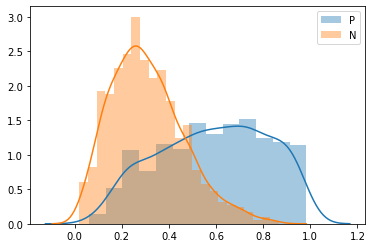

In [832]:
sns.distplot(y_pred_score[y_test==1], label = 'P')
sns.distplot(y_pred_score[y_test==0], label = 'N')
plt.legend()

In [833]:
top_FP = y_test[y_test==0].iloc[np.argpartition(y_pred_score[y_test==0], -4)[-4:][::-1]].index.tolist()
top_FN = y_test[y_test==1].iloc[np.argpartition(y_pred_score[y_test==1], 4)[:4]].index.tolist()

In [834]:
top_FP

[9619, 7491, 615, 7292]

In [835]:
shap_values = {k: shap_values[idx,:] for idx, k in enumerate(X_test.index)}

TypeError: unhashable type: 'slice'

In [828]:
data.loc[top_FP]

,keyword,location,text,target
id,,,,
9619,thunderstorm,Sydney,Beautiful lightning as seen from plane window ...,0
7491,obliteration,India,He is justifying why this quarrel would one da...,0
615,arsonist,"Orange County, California",Video Captures Man Removing American Flag From...,0
7292,nuclear%20disaster,Fukushima city Fukushima.pref,Over half of poll respondents worry nuclear di...,0


In [829]:
ididid = top_FP[0]

In [830]:
data.loc[top_FP[0]].text

'Beautiful lightning as seen from plane window http://t.co/5CwUyLnFUm http://t.co/1tyYqFz13D'

In [831]:
X_test.loc[[top_FP[0]]]

,text_count_urls,text_count_large_words,text_count_small_words,text_count_words,text_count_large_words_frac,text_forest,text_near,text_shelter,text_california,text_smoke,...,location_yuukosans,location_usadraenor,location_still,location_cambridgeshire,location_kaumelitefvorsmofc,location_need,location_nyaman,location_kaduna,location_gangsta,location_book
id,,,,,,,,,,,,,,,,,,,,,
9619,2,1,8,9,0.10989,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [724]:
shap_values[top_FP[0]]

array([ 5.13729829e-01,  9.65350386e-05, -4.10436940e-06, ...,
       -1.33885577e-04,  6.82145938e-04,  1.40299956e-04])

In [725]:
shap.force_plot(explainer.expected_value, shap_values[top_FP[0]], X_test.loc[[top_FP[0]]], link="logit")

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)